# GMEAN of models

https://www.kaggle.com/paulorzp/gmean-of-light-gbm-models-lb-0-9484

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob

from scipy.stats import describe
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
LABELS = ["isFraud"]
all_files = glob.glob("../../data/submissions/final/*.csv")
all_files

['../../data/submissions/final\\lgb_folds_umap_0818.csv',
 '../../data/submissions/final\\lgb_preds_0828.csv',
 '../../data/submissions/final\\xgb_folds_0817.csv',
 '../../data/submissions/final\\xgb_folds_umap_0819.csv',
 '../../data/submissions/final\\xgb_preds_0828.csv']

In [5]:
outs = [pd.read_csv(f, index_col=0) for f in all_files]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "m" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols
concat_sub.reset_index(inplace=True)

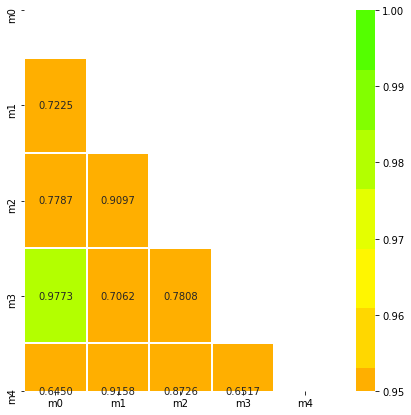

In [6]:
# check correlation
corr = concat_sub.iloc[:,1:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(len(cols)+2, len(cols)+2))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask,cmap='prism',vmin=0.95,center=0,linewidths=1,annot=True,fmt='.4f')

In [7]:
rank = np.tril(concat_sub.iloc[:,1:].corr().values,-1)
m = (rank>0).sum()
m_gmean, s = 0, 0
for n in range(min(rank.shape[0],m)):
    mx = np.unravel_index(rank.argmin(), rank.shape)
    w = (m-n)/(m+n)
    print(w)
    m_gmean += w*(np.log(concat_sub.iloc[:,mx[0]+1])+np.log(concat_sub.iloc[:,mx[1]+1]))/2
    s += w
    rank[mx] = 1
m_gmean = np.exp(m_gmean/s)

1.0
0.8181818181818182
0.6666666666666666
0.5384615384615384
0.42857142857142855


In [8]:
describe(m_gmean)

DescribeResult(nobs=506691, minmax=(0.00020705192789280326, 0.9980329419491508), mean=0.021301608356925305, variance=0.011152981408617476, skewness=8.24794826575914, kurtosis=69.46481854765658)

In [9]:
concat_sub['isFraud'] = m_gmean
concat_sub[['TransactionID','isFraud']].to_csv('../../data/submissions/stack_gmean.csv', 
                                        index=False, float_format='%.4g')